In [11]:
import pytorch_lightning as pl
from glob import glob
import torch
import os

from datasets import MnistDataModule
from modelling import CNN
from modelling.pretrained import resnet18_trained_on_mnist, lenet_trained_on_mnist, lenet_trained_on_fashion_mnist
from experiments.rejectron.rejectron import RejectronClassifier

from tqdm import tqdm
import matplotlib.pyplot as plt

os.chdir(f'/voyager/projects/tomginsberg/pqlearning')

In [18]:
checkpoints = sorted(
    glob('checkpoints/rejectron_fashion_mnist_p5_r45-90_c2-d8_lenet/c*/*ckpt'),
    # sort by model num in "checkpoints/rejectron_mnist/c_(model num)"
    key=lambda x: int(x.split('/')[2].split('_')[-1])
)
rejectors = [lenet_trained_on_fashion_mnist().cuda(device=2)] + \
            [CNN.load_from_checkpoint(checkpoint_path=checkpoint).cuda(device=2) for checkpoint in tqdm(checkpoints)]

mnist = MnistDataModule(shift_transform_type='natural', test_transform_rate=.5, rotation=(45,90), crop=.2, distortion=.8,
                        batch_size=256, fashion_mnist=True)

100%|███████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 120.03it/s]


In [19]:
y_true = []
y_pred = []
for x, y in tqdm(mnist.test_dataloader()):
    x = x.cuda(device=2)
    y_true.append(y)
    y_pred.append(torch.stack([f(x).argmax(1).cpu() for f in rejectors]))

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred, dim=1)

Global seed set to 42
100%|██████████████████████████████████████████████████████████████| 40/40 [00:04<00:00,  9.81it/s]


In [20]:
accs = []
rejs = []
y_true_tmp = y_true.clone()
mask = torch.ones_like(y_true, dtype=bool)
for pred in tqdm(y_pred):
    pred_m = pred[mask]
    true_m = y_true_tmp[mask]
    
    pred_mask = pred_m == true_m
    acc = (pred_mask).float().mean()
    rej = 1 - mask.float().mean()
    
    # update the mask
    if not mask.all():
        y_true_tmp[~mask] = -1
    mask = y_true_tmp == pred
    
    accs.append(acc)
    rejs.append(rej)

accs = torch.tensor(accs)
rejs = torch.tensor(rejs)

100%|████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1296.06it/s]


In [21]:
# baseline, dont cirruot any of thr test data
mnist = MnistDataModule(shift_transform_type='natural', test_transform_rate=0, rotation=(20,40), crop=.3, distortion=.3,
                        batch_size=256, fashion_mnist=True)

y_true = []
y_pred = []
for x, y in tqdm(mnist.test_dataloader()):
    x = x.cuda(device=2)
    y_true.append(y)
    y_pred.append(torch.stack([f(x).argmax(1).cpu() for f in rejectors]))

y_true = torch.cat(y_true)
y_pred = torch.cat(y_pred, dim=1)

Global seed set to 42
100%|██████████████████████████████████████████████████████████████| 40/40 [00:01<00:00, 22.48it/s]


In [22]:
accs_bs = []
rejs_bs = []
y_true_tmp = y_true.clone()
mask = torch.ones_like(y_true, dtype=bool)
for pred in tqdm(y_pred):
    pred_m = pred[mask]
    true_m = y_true_tmp[mask]
    
    pred_mask = pred_m == true_m
    acc = (pred_mask).float().mean()
    rej = 1 - mask.float().mean()
    
    # update the mask
    if not mask.all():
        y_true_tmp[~mask] = -1
    mask = y_true_tmp == pred
    
    accs_bs.append(acc)
    rejs_bs.append(rej)

accs_bs = torch.tensor(accs_bs)
rejs_bs = torch.tensor(rejs_bs)

100%|█████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 864.70it/s]


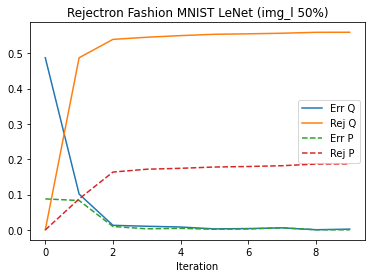

In [24]:
rng = range(len(accs))
plt.plot(rng, 1-accs, label='Err Q')
plt.plot(rng, rejs, label='Rej Q' )

plt.plot(rng, 1-accs_bs,'--', label='Err P')
plt.plot(rng, rejs_bs,'--', label='Rej P' )

plt.legend()
plt.title('Rejectron Fashion MNIST LeNet (img_l 50%)')
plt.xlabel('Iteration')
plt.savefig('notebooks/rejectron_fashion_mnist_img_l_lenet.pdf')

Text(0.5, 1.0, 'Rejectron MNIST (img_m 50%)')

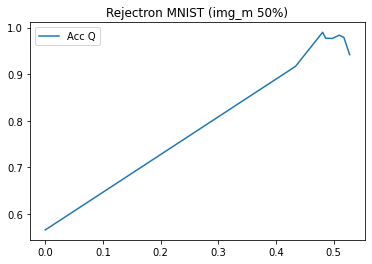

In [10]:
rng = range(len(accs))
plt.plot(rejs, accs, label='Acc Q')

plt.legend()
plt.title('Rejectron MNIST (img_m 50%)')

<module 'matplotlib.pyplot' from '/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/matplotlib/pyplot.py'>

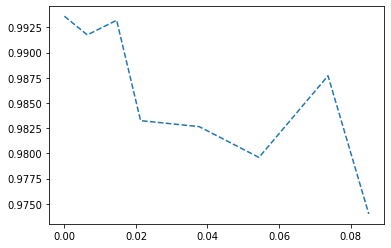

In [11]:
plt.plot(rejs_bs, accs_bs,'--', label='Acc P')
plt

In [9]:
rejs_bs[-1]

tensor(0.0124)

In [10]:
rejs[-1]

tensor(0.4934)